In [1]:
%matplotlib inline
import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
import igraph as ig

In [3]:
num_iter = 10;
N = 100;
k_min = 1
k_max = 25
ps = range(k_min,k_max);

In [4]:
from scipy.optimize import fsolve, fmin, root
import sympy as sy
from mis_utils import *

 ## simple example of solution for gaussian degree-distributed networks

In [5]:
N = 100
k_min = 1
k_max = 50
pmin = k_min/float(N);
pmax = k_max/float(N);
psp = range(k_min,k_max,1);

In [6]:
x_p = range(0,11);
p_stars = []
for l in x_p:
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )

RuntimeError: matplotlib does not support generators as input

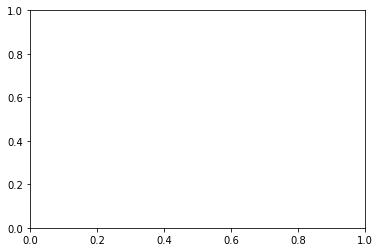

In [7]:
c = 2
pss = np.linspace(ps[0],ps[-1],100)
xs = np.linspace(0,1,5000);
plt.plot(pss, map(lambda x: minimize_gauss_pstar(xs, x, 4,c), pss),'.', label = '4')
plt.plot(pss, map(lambda x: minimize_gauss_pstar(xs, x, 3,c), pss),'.', label = '3')
plt.plot(pss, map(lambda x: minimize_gauss_pstar(xs, x, 2,c), pss),'.', label = '2')
plt.plot(pss, map(lambda x: minimize_gauss_pstar(xs, x, 1.5,c), pss),'.', label = '1.5')
plt.plot(pss, map(lambda x: minimize_gauss_pstar(xs, x, 1,c), pss),'.', label = '1')
plt.legend(loc=0)

In [ ]:
# define the colormap
cmap = plt.cm.hot
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [ ]:
x_p = range(k_min,k_max,1);
p_stars = []
for l in x_p:
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )

In [ ]:
n_sigmas = np.linspace(0,2,11)#range(1,5);
sigmas = {}
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(12,10))
for ii,n_sigma in tqdm_notebook(enumerate(n_sigmas)):
    print n_sigma
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    plt.plot(pss, gaussian_prediction(pss, sigmas,xs=np.linspace(0,1,10000)),'--s',color=cmap(ii*30), label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$')
plt.legend(loc=0)

x_p = range(k_min,k_max,1);
p_stars = []
for l in tqdm_notebook(x_p):
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )
plt.plot(x_p,rhos,'-')

# Comparison with simulations

In [ ]:
n_sigmas_redux = [ 0. ,  0.4, 0.8,  1. ,  1.2,  1.6 ]

In [ ]:
num_iter = 20;
N = 50;

res_ig = {};
res_ig_fg = {}
res_ig_fg_v1 = {}
res_ig_fg_v2 = {}
res_ig_fg_clique = {}
res_leaf_branch = {}
res_leaf_core = {}
av_k_ig = {}
n_ig_dict = {}
import time
from datetime import datetime

import igraph as igg

from scipy.stats import norm
xs = np.linspace(0,1,10000)

for n_sigma in tqdm_notebook(n_sigmas_redux):
    print n_sigma;
    res_ig[n_sigma] = {};
    av_k_ig[n_sigma] = {};
    n_ig_dict[n_sigma] = {};

    for l,p in tqdm_notebook(enumerate(pss)):
        print l, '/', len(pss), ':', p, 'started:', str(datetime.now())
        res_ig[n_sigma][p] = []
        av_k_ig[n_sigma][p] = [];
        n_ig_dict[n_sigma][p] = []
        for it in range(num_iter):
            deg = map(lambda x: np.max([0, int(x)]), norm.rvs(p,n_sigma*np.sqrt(p),N));
            if not np.sum(deg)%2==0:
                deg[0]+=1;
            g = nx.configuration_model(deg) # DIRECT generation of the graph 
            av_k_ig[n_sigma][p].append(np.mean(g.degree().values())); # average degree
            n_g = g.number_of_nodes() ## this is the number of nodes, used to normalize the alpha number found below
            n_ig_dict[n_sigma][p].append(n_g); # number of IG nodes (tasks)
            nx.write_gml(g,'test.gml'); #horrible trick to pass from nx to ig
            g_igraph = igg.load('test.gml')
            res_ig[n_sigma][p].append( g_igraph.alpha() / float(n_g) )   # density of the IG MIS (properly normalized)

In [ ]:
cmap = plt.cm.hot
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [ ]:
n_sigmas = np.linspace(0,2,11)#range(1,5);
sigmas = {}
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(20,20))
preds_df = pd.DataFrame()
for i, n_sigma in enumerate(sorted(res_ig.keys())):
    plt.subplot(4,3,i+1)
    print n_sigma
    data = res_ig[n_sigma]
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.errorbar(pss, yy,std_yy,fmt='o', color=cmap(i*150/len(sorted(res_ig.keys())[1::])),alpha=0.5)
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);

    y = gaussian_prediction(pss, sigmas, xs=np.linspace(0,1,5000));    # theoretical prediction of rho_alpha 
    plt.plot(pss,y,'--k', label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$',color=cmap(i*150/len(sorted(res_ig.keys())[1::])))
    preds_df[n_sigma] = pd.Series(y,pss)
    plt.legend(loc=0, fontsize=25)
    plt.plot(x_p,rhos,'-k',alpha=0.7)
#     plt.xlim(0,20)

In [ ]:
n_sigmas = np.linspace(0,2,11)#range(1,5);
sigmas = {}
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(20,20))
preds_df = pd.DataFrame()
for i, n_sigma in enumerate(sorted(res_ig.keys())):
    plt.subplot(4,3,i+1)
    print n_sigma
    data = res_ig[n_sigma]
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.errorbar(pss, yy,std_yy,fmt='o',color=cmap(i*150/len(sorted(res_ig.keys())[1::])),alpha=0.5)
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    y = gaussian_prediction(pss, sigmas,xs=np.linspace(0,1,5000));
    plt.plot(pss,y,'--k', label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$',color=cmap(i*150/len(sorted(res_ig.keys())[1::])))
    preds_df[n_sigma] = pd.Series(y,pss)
    plt.legend(loc=0, fontsize=25)

    x_p = range(k_min,k_max,1);
    plt.plot(x_p,rhos,'-k',alpha=0.7)
    plt.xlim(0,20)
    plt.yscale('log')
    plt.xscale('log')
##plt.savefig('../../submission/si/plots/heterogeneity_role.pdf',dpi=600)

In [ ]:
fig = plt.figure(figsize=(10,8))
for i, n_sigma in enumerate(sorted(res_ig.keys())[1::]):
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    data = res_ig[n_sigma]
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    x_p = range(k_min,k_max,1);
    plt.plot(x_p,rhos,'-k')
    plt.errorbar(pss,yy,std_yy, ms=15,alpha=0.3,color=cmap(i*150/len(sorted(res_ig.keys())[1::])),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
    plt.plot(pss, preds_df[n_sigma],'-',color=cmap(10+i*150/len(sorted(res_ig.keys())[1::2])),
             label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$',lw=3)
    plt.legend(loc=2)
plt.xlim(5,20)
plt.yscale('log')
#plt.xscale('log')


In [ ]:
preds_df.plot()

In [ ]:
res_ig_df = {}
for k in sorted(res_ig.keys()):
    res_ig_df[k] = {}
    for p in sorted(res_ig[k].keys()):
        res_ig_df[k][p] = np.nanmean(res_ig[k][p])
res_ig_df = pd.DataFrame(res_ig_df)
res_ig_df.head()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
for c in res_ig_df.columns:
    plt.plot(res_ig_df[c],'o')
preds_df.plot(ax=ax)
ax = plt.subplot(122)
for c in res_ig_df.T.columns[1::9]:
    plt.plot(res_ig_df.T[c],'o-')
#preds_df.T[pss[1::7]].plot(ax=ax)

In [ ]:
# define the colormap
cmap = plt.cm.hot
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [ ]:
n_sigmas_redux = sorted(res_ig.keys()[1::])
preds = {}
for i, n_sigma in enumerate(n_sigmas_redux):
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    preds[n_sigma] = gaussian_prediction(pss, sigmas,xs=np.linspace(0,1,5000));

In [ ]:
plt.style.use('seaborn-white')
fs = 30
sigmas = {}
fig = plt.figure(figsize=(8,8))
for i, n_sigma in enumerate(sorted(res_ig.keys())[1::2]):
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    data = res_ig[n_sigma]
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.errorbar(pss,yy,std_yy, ms=30,alpha=0.8,color=cmap(i*250/len(sorted(res_ig.keys())[1::2])),fmt='.',lw=2,mew=1.5,mec='k')#,label = n_sigma)
    plt.plot(pss, preds[n_sigma],'-',color=cmap(i*200/len(sorted(res_ig.keys())[1::2])),
             label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$',lw=3)
    plt.legend(loc=0,fontsize=fs)
#x_p = range(k_min,k_max,1);
#plt.plot(x_p,rhos,'--k',lw=3)
plt.xlim(0.5,20)
plt.ylim(0.2,.8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\langle k \rangle$', fontsize=fs)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.box('off')
plt.grid('off')
plt.tight_layout()
#plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects.pdf')
# #plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects.eps')
# #plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects.svg')

In [ ]:
plt.style.use('seaborn-white')
fs = 30
sigmas = {}
fig = plt.figure(figsize=(8,4))
for i, n_sigma in enumerate(sorted(res_ig.keys())[1::2]):
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    data = res_ig[n_sigma]
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.errorbar(pss,yy,std_yy, ms=20,alpha=0.8,color=cmap(i*250/len(sorted(res_ig.keys())[1::2])),fmt='.',lw=2,mew=1.5,mec='k')#,label = n_sigma)
    plt.plot(pss, preds[n_sigma],'-',color=cmap(i*250/len(sorted(res_ig.keys())[1::2])),
             label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$',lw=3)
#plt.legend(loc=0)
#x_p = range(k_min,k_max,1);
#plt.plot(x_p,rhos,'--k',lw=3)
#plt.xlim(2,20)
#plt.ylim(0.2,1)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\mu$', fontsize=fs)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

#plt.box('off')
plt.grid('off')
plt.tight_layout()
#plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects_inset.pdf')
##plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects_inset.eps')
##plt.savefig('../../notes/natphys-submission/plots/heterogeneity-effects_inset.svg')

## Heterogeneity simulations 

In [ ]:
num_iter = 10;
N = 75;

het_res_ig = {};
het_av_k_ig = {}
het_n_ig_dict = {}
import time
from datetime import datetime

import igraph as igg

from scipy.stats import norm
het_sigma = np.linspace(0.2,1.4,10)

for p in [15,20,25,30,35]:
    print p;
    het_res_ig[p] = {};
    het_av_k_ig[p] = {};
    het_n_ig_dict[p] = {};

    for l,sig in enumerate(het_sigma):
        print l, '/', len(het_sigma), ':', sig, 'started:', str(datetime.now())
        het_res_ig[p][sig] = []
        het_av_k_ig[p][sig] = [];
        het_n_ig_dict[p][sig] = []
        for it in range(num_iter):
            deg = map(lambda x: np.max([0, int(x)]), norm.rvs(p,sig*np.sqrt(p),N));
            if not np.sum(deg)%2==0:
                deg[0]+=1;
            g = nx.configuration_model(deg)
            het_av_k_ig[p][sig].append(np.mean(g.degree().values()));
            n_g = g.number_of_nodes()
            het_n_ig_dict[p][sig].append(n_g);
            nx.write_gml(g,'test.gml');
            g_igraph = igg.load('test.gml')
            het_res_ig[p][sig].append( g_igraph.alpha() / float(n_g) )  


In [ ]:
preds_het = {}
for sig in het_sigma:
    preds_het[sig] = []
    sigmas = map(lambda x: np.sqrt(x)*sig, sorted(het_res_ig.keys()));
    preds_het[sig] = pd.Series(gaussian_prediction(sorted(het_res_ig.keys()), sigmas, xs=np.linspace(0,1,10000)), index=sorted(het_res_ig.keys()));

In [ ]:
for p in sorted(het_res_ig.keys()):
    plot_results(het_sigma, het_res_ig[p],label = p)

preds_het_df = pd.DataFrame(preds_het).T
preds_het_df.plot()
#plt.plot(het_sigma,preds_het,label=p)
#plt.legend(loc=0)
#plt.ylim(0,0.7)
#plt.tight_layout()

# Simulation-driven comparison with IG 

In [ ]:
num_iter = 10;
nN = 20;

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_gauss_pred = {}

import time
from datetime import datetime

import igraph as igg
new_k_min = 1
new_k_max = 15
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
precision = 30
new_ps = np.linspace(new_pmin,new_pmax,precision);

from scipy.stats import norm
#rvs(loc=0, scale=1, size=1, random_state=None)

for l,p in enumerate(new_ps):
    print l, '/', precision, ':', p, 'started:', str(datetime.now())
    new_gauss_pred[p] = []
    new_res_ig[p] = []
    new_av_k_ig[p] = [];
    new_n_ig_dict[p] = []
    for it in range(num_iter):
        g = igt.create_ER_bipartite_graph(nN,p)
        lg = igt.line_graph(g)
        ig = igt.interference_graph(lg)
        new_av_k_ig[p].append(np.mean(ig.degree().values()));
        new_n_ig = ig.number_of_nodes()
        new_n_ig_dict[p].append(new_n_ig);
        nx.write_gml(ig,'test.gml');
        g_igraph = igg.load('test.gml')
        new_res_ig[p].append( g_igraph.alpha() )    
        mu = np.mean(g.degree().values());
        sigma =  np.std(g.degree().values());
        p_stars_gauss = minimize_gauss_pstar(xs,mu,sigma**2, 2);
        new_gauss_pred[p].append(rho_gauss(p_stars_gauss, mu , sigma**2,2));

In [ ]:
fs = 30
fig = plt.figure(figsize=(8,8))
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150), label='Pred. bounds')

data = new_res_ig
yy = map(lambda x: np.mean(data[x])/nN, sorted(data.keys()));
std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
plt.errorbar(new_ps,yy,std_yy, ms=20,alpha=0.5,color=cmap(100),fmt='.',lw=2,mew=1.5,mec='k',label = r'Sim $\rho_\alpha$')
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$\langle k \rangle/N$', fontsize=fs)
plt.box('off')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=0, fontsize=30)
plt.tight_layout()
##plt.savefig('../../notes/natphys-submission/plots/IG_sim_vs_solution.eps')
#plt.savefig('../../notes/natphys-submission/plots/IG_sim_vs_solution.pdf')
##plt.savefig('../../notes/natphys-submission/plots/IG_sim_vs_solution.png')
##plt.savefig('../../notes/natphys-submission/plots/IG_sim_vs_solution.svg')

In [ ]:
fs = 15
fig = plt.figure(figsize=(5,4))
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150))

data = new_res_ig
yy = map(lambda x: np.mean(data[x])/nN, sorted(data.keys()));
std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
plt.errorbar(new_ps,yy,std_yy, ms=15,alpha=0.4,color=cmap(100),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$z/N$', fontsize=fs)
plt.box('off')
plt.legend(loc=0)
plt.tight_layout()


## Probability of performing $\beta$ tasks from a task set of dimension $\gamma$

$p(\beta ; \gamma) = \binom{\gamma}{\beta} \frac{M_{out}!}{(M_{out} - M_{in})!} M^{-M_{in}} M^{-(\gamma-\beta)} 
\frac{M_{in}! z^{\gamma-\beta}}{(M_{in} - (\gamma-\beta)!}$

In [ ]:
from scipy.special import binom
def log_prob_beta_gamma(beta, gamma, M, zeta):
    s = 0; 
    Min = zeta*beta;
    Mout = M - zeta*beta;
    s += np.log(binom(gamma,beta))
    s += np.sum(map(np.log, range(1,Mout +1 ))) #the plus one is for the range function only, not in the math
    s -= np.sum(map(np.log, range(1,Mout - Min +1 )))
    s -= Min * np.log(M);
    s -= (gamma - beta) * np.log(M/float(zeta));
    s += np.sum(map(np.log, range(1, Min +1)))
    s -= np.sum(map(np.log, range(1, Min -(gamma-beta) +1)))
    return s;
    
def average_beta_gamma(gamma, M, zeta):
    probs = map(lambda x: np.exp(log_prob_beta_gamma(x,gamma, M, zeta)), range(1,gamma+1));
    Z_fun = np.sum(probs);
    s = 0;
    for i, beta in enumerate(range(1,gamma+1)):
        s += beta * probs[i] / Z_fun;
    return s;

In [ ]:
import time

fig = plt.figure(figsize=(12,5))
ns = range(100,400,30);
rhos = np.linspace(0.1,0.9,15) #[0.1,0.2, 0.4, 0.7]

renorm_max_performance  = pd.DataFrame(columns=rhos,index=ns)
max_performance  = pd.DataFrame(columns=rhos,index=ns)

now = time.time();
for rho in rhos:
    print rho, time.time() - now;
    Ms = map(int, np.array(ns)*(np.array(ns)-1)*rho/2);
    ks = 2*np.array(Ms)/np.array(ns)
    alphas = map(int, np.array(gaussian_prediction(ks, map(np.std,ks), xs=np.linspace(0,1,50000))) * ns); 
    avs = map(lambda x: average_beta_gamma(alphas[x],Ms[x],ks[x]), range(len(ns)));
    plt.subplot(121)
    plt.plot(ns, avs, label=str(rho))
    plt.subplot(122)
    plt.plot(ns, avs / np.array(ns), label=str(rho))
    renorm_max_performance[rho] = pd.Series(avs / np.array(ns), ns);
    max_performance[rho] = pd.Series(avs, ns);

plt.subplot(121)
plt.legend(loc=0)
plt.subplot(122)
plt.legend(loc=0)
plt.tight_layout()

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(122)
sns.heatmap(renorm_max_performance, ax=ax);
plt.title('Normalized performance')
ax = plt.subplot(121)
sns.heatmap(max_performance, ax=ax);
plt.title('Raw performance')
plt.tight_layout()


In [ ]:
probs = map(lambda x: log_prob_beta_gamma(x,alphas[5],Ms[5],ks[5]), range(1,alphas[5]));
plt.plot(range(1,alphas[5]), probs,'.')

In [ ]:
no_nodes = 20
prob_link = 0.4
g = nx.erdos_renyi_graph(no_nodes,prob_link)
z = int(np.mean(nx.degree(g).values()))
g = nx.random_regular_graph(z,no_nodes)
M = 2*g.number_of_edges()

alpha = nx.maximal_independent_set(g)
gamma_nodes = range(len(alpha));
print len(alpha), z, int(z)

print average_beta_gamma(len(alpha), M, int(z))

In [ ]:
pb = []
for beta in range(0,g.number_of_nodes()):
    pb.append(np.exp(log_prob_beta_gamma(beta, len(alpha), M, z)))
pb = np.array(pb)/float(np.sum(pb));
plt.plot(range(0,g.number_of_nodes()),pb)
print np.sum(np.array(range(0,g.number_of_nodes()))*pb)

In [ ]:
g = nx.random_regular_graph(10,100)
print np.mean(nx.clustering(g).values())
g = nx.random_regular_graph(20,100)
print np.mean(nx.clustering(g).values())
g = nx.random_regular_graph(30,100)
print np.mean(nx.clustering(g).values())    